In [1]:
from load_data import get_mfcc, get_spectrogram
import matplotlib.pyplot as plt

import os
import pandas as pd
import json
import numpy as np
import librosa

In [2]:
os.environ["SM_FRAMEWORK"] = "tf.keras"

Analyze signal shapes

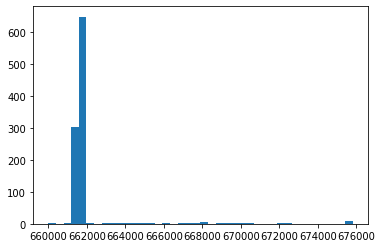

In [3]:
DATASET_PATH = 'data'

signal_shape = []
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        signal, sample_rate = librosa.load(file_path)
        signal_shape.append(signal.shape[0])

plt.hist(signal_shape, bins=40)
plt.show()

In [4]:
MINIMAL_SHAPE = min(set(signal_shape))
MAXIMAL_SHAPE = max(set(signal_shape))

Prepare dataset

In [5]:
# Calculate number of songs
NUM_OF_GENRES = 10
NUM_OF_SONGS_PER_GENRE = 100
INVALID_SONGS = 2
NUM_OF_SONGS = NUM_OF_GENRES * NUM_OF_SONGS_PER_GENRE - INVALID_SONGS

# Calculate shape of input
EXAMPLE_SONG_PATH = 'data/blues/blues.00000.wav'
input_data_shape = get_mfcc(EXAMPLE_SONG_PATH, 2048, 512, 14, MINIMAL_SHAPE).shape

# Alocate memory to array
x = np.ndarray(shape=(NUM_OF_SONGS, input_data_shape[0], input_data_shape[1]), dtype=np.float32)
y = []


In [6]:
# Create dataset arrays

DATASET_PATH = 'data'

i = 0
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        spectrogram = get_mfcc(file_path, 2048, 512, 14, MINIMAL_SHAPE)
        label = file.split(".")[0]
        x[i] = spectrogram
        y.append(label)
        i += 1        

In [7]:
input_data_shape

(14, 1290)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [15]:
from sklearn.preprocessing import LabelEncoder

y_train = np.array(y_train)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

y_test = np.array(y_test)
y_test = label_encoder.transform(y_test)

In [12]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

AttributeError: module 'tensorflow' has no attribute 'keras'

In [16]:
import keras
from keras import layers

model = keras.Sequential()
model.add(layers.Flatten(input_shape=input_data_shape))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

ImportError: cannot import name 'tf2' from 'tensorflow.python' (unknown location)

In [ ]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 18060)             0         
                                                                 
 dense_4 (Dense)             (None, 32)                577952    
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 578,282
Trainable params: 578,282
Non-trainable params: 0
_________________________________________________________________


In [54]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=128
)

Epoch 1/5


AttributeError: in user code:

    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\engine\training.py:791 train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:522 minimize
        return self.apply_gradients(grads_and_vars, name=name)
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:655 apply_gradients
        grads_and_vars = self._aggregate_gradients(grads_and_vars)
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:474 _aggregate_gradients
        return self.gradient_aggregator(grads_and_vars)
    c:\Anaconda3\envs\music_gengre_class\lib\site-packages\keras\optimizer_v2\utils.py:33 all_reduce_sum_gradients
        if strategy_supports_no_merge_call():

    AttributeError: module 'tensorflow.compat.v2.__internal__.distribute' has no attribute 'strategy_supports_no_merge_call'


In [55]:
!pip uninstall keras -y
!pip uninstall keras-nightly -y
!pip uninstall keras-Preprocessing -y
!pip uninstall keras-vis -y
!pip uninstall tensorflow -y

!pip install tensorflow==2.3.0
!pip install keras==2.4

Found existing installation: keras 2.6.0
Uninstalling keras-2.6.0:
  Successfully uninstalled keras-2.6.0


Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2


ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0)
ERROR: No matching distribution found for tensorflow==2.3.0


^C
